In [175]:
#data analysis and wrangling 
import numpy as np
import pandas as pd 

#data visualisation
import seaborn as sns
import matplotlib.pyplot as plt

#statistics
from statistics import stdev
from scipy.stats import t 

#dates
import matplotlib.dates as mdates 


In [176]:
#load data
qvidata = pd.read_csv('/Users/leesunny/Downloads/QVI_data.csv')

In [177]:
#look up the data 
qvidata.head()

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream


In [178]:
#check for nulls 
qvidata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264834 entries, 0 to 264833
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   LYLTY_CARD_NBR    264834 non-null  int64  
 1   DATE              264834 non-null  object 
 2   STORE_NBR         264834 non-null  int64  
 3   TXN_ID            264834 non-null  int64  
 4   PROD_NBR          264834 non-null  int64  
 5   PROD_NAME         264834 non-null  object 
 6   PROD_QTY          264834 non-null  int64  
 7   TOT_SALES         264834 non-null  float64
 8   PACK_SIZE         264834 non-null  int64  
 9   BRAND             264834 non-null  object 
 10  LIFESTAGE         264834 non-null  object 
 11  PREMIUM_CUSTOMER  264834 non-null  object 
dtypes: float64(1), int64(6), object(5)
memory usage: 24.2+ MB


In [179]:
#select control stores
#trail store=77, 86, 88
#trail period= feb 2019 

In [180]:
#date formate to yyyymm 
qvidata["DATE"] = pd.to_datetime(qvidata["DATE"])
qvidata["YEARMONTH"] = qvidata["DATE"].dt.strftime("%Y%m").astype("int")

In [181]:
#compile each store's monthly
def monthly_store_metrics():
    store_yrmo_group = qvidata.groupby(["STORE_NBR", "YEARMONTH"])
    total = store_yrmo_group["TOT_SALES"].sum()
    num_cust = store_yrmo_group["LYLTY_CARD_NBR"].nunique()
    trans_per_cust = store_yrmo_group.size() / num_cust
    avg_chips_per_cust = store_yrmo_group["PROD_QTY"].sum() / num_cust
    avg_chips_price = total / store_yrmo_group["PROD_QTY"].sum()
    aggregates = [total, num_cust, trans_per_cust, avg_chips_per_cust, avg_chips_price]
    metrics = pd.concat(aggregates, axis=1)
    metrics.columns = ["TOT_SALES", "nCustomers", "nTxnPerCust", "nChipsPerTxn", "avgPricePerUnit"]
    return metrics


In [182]:
#pre trial observation
qvi_monthly_metrics=monthly_store_metrics().reset_index()
qvi_monthly_metrics.info()
print(qvi_monthly_metrics)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3169 entries, 0 to 3168
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   STORE_NBR        3169 non-null   int64  
 1   YEARMONTH        3169 non-null   int64  
 2   TOT_SALES        3169 non-null   float64
 3   nCustomers       3169 non-null   int64  
 4   nTxnPerCust      3169 non-null   float64
 5   nChipsPerTxn     3169 non-null   float64
 6   avgPricePerUnit  3169 non-null   float64
dtypes: float64(4), int64(3)
memory usage: 173.4 KB
      STORE_NBR  YEARMONTH  TOT_SALES  nCustomers  nTxnPerCust  nChipsPerTxn  \
0             1     201807      206.9          49     1.061224      1.265306   
1             1     201808      176.1          42     1.023810      1.285714   
2             1     201809      278.8          59     1.050847      1.271186   
3             1     201810      188.1          44     1.022727      1.318182   
4             1     201811  

In [183]:
# Filter to the pre-trial period and stores with full observation periods
observ_counts = qvi_monthly_metrics["STORE_NBR"].value_counts()
full_observ_index = observ_counts[observ_counts == 12].index
full_observ = qvi_monthly_metrics[qvi_monthly_metrics["STORE_NBR"].isin(full_observ_index)]
pretrial_full_observ = full_observ[full_observ["YEARMONTH"] < 201902]

pretrial_full_observ.head()

,STORE_NBR,YEARMONTH,TOT_SALES,nCustomers,nTxnPerCust,nChipsPerTxn,avgPricePerUnit
0,1,201807,206.9,49,1.061224,1.265306,3.337097
1,1,201808,176.1,42,1.023810,1.285714,3.261111
2,1,201809,278.8,59,1.050847,1.271186,3.717333
3,1,201810,188.1,44,1.022727,1.318182,3.243103
4,1,201811,192.6,46,1.021739,1.239130,3.378947


In [184]:
#calculcate how correlated the performance 
#define inputTable as a metric table with potential comparison stores,
#metricCol as the store metric used to calculate correlation on
#storeComparison as the store number of the trial store

def calcCorrTable(metricCol, storeComparison, inputTable=pretrial_full_observ):
    control_store_nbrs = inputTable[~inputTable["STORE_NBR"].isin([77, 86, 88])]["STORE_NBR"].unique()
    corrs = pd.DataFrame(columns = ["YEARMONTH", "Trial_Str", "Ctrl_Str", "Corr_Score"])
    trial_store = inputTable[inputTable["STORE_NBR"] == storeComparison][metricCol].reset_index()
    for control in control_store_nbrs:
        concat_df = pd.DataFrame(columns = ["YEARMONTH", "Trial_Str", "Ctrl_Str", "Corr_Score"])
        control_store = inputTable[inputTable["STORE_NBR"] == control][metricCol].reset_index()
        concat_df["Corr_Score"] = trial_store.corrwith(control_store, axis=1)
        concat_df["Trial_Str"] = storeComparison
        concat_df["Ctrl_Str"] = control
        concat_df["YEARMONTH"] = list(inputTable[inputTable["STORE_NBR"] == storeComparison]["YEARMONTH"])
        corrs = pd.concat([corrs, concat_df])
    return corrs
           

In [185]:
corr_table = pd.DataFrame()
for trial_num in [77, 86, 88]:
    corr_table = pd.concat([corr_table, calcCorrTable(["TOT_SALES", "nCustomers", "nTxnPerCust", "nChipsPerTxn", "avgPricePerUnit"], trial_num)])
corr_table.head(10)


,YEARMONTH,Trial_Str,Ctrl_Str,Corr_Score
0,201807,77,1,0.070414
1,201808,77,1,0.027276
2,201809,77,1,0.002389
3,201810,77,1,-0.020045
4,201811,77,1,0.030024
5,201812,77,1,0.063946
6,201901,77,1,0.001470
0,201807,77,2,0.142957
1,201808,77,2,0.097595
2,201809,77,2,0.077981


In [186]:
#calculate absolute difference between the trial store's performance and each control store's performance.
def calculateMagnitudeDistance(metricCol, storeComparison, inputTable=pretrial_full_observ):
    control_store_nbrs = inputTable[~inputTable["STORE_NBR"].isin([77, 86, 88])]["STORE_NBR"].unique()
    dists = pd.DataFrame()
    trial_store = inputTable[inputTable["STORE_NBR"] == storeComparison][metricCol]
    for control in control_store_nbrs:
        concat_df  = abs(inputTable[inputTable["STORE_NBR"] == storeComparison].reset_index()[metricCol] - inputTable[inputTable["STORE_NBR"] == control].reset_index()[metricCol])
        concat_df["YEARMONTH"] = list(inputTable[inputTable["STORE_NBR"] == storeComparison]["YEARMONTH"])
        concat_df["Trial_Str"] = storeComparison
        concat_df["Ctrl_Str"] = control
        dists = pd.concat([dists, concat_df])
    for col in metricCol:
        dists[col] = 1 - ((dists[col] - dists[col].min()) / (dists[col].max() - dists[col].min()))
    dists["magnitude"] = dists[metricCol].mean(axis=1)
    return dists    
    

In [187]:
dist_table = pd.DataFrame()
for trial_num in [77, 68, 88]:
     dist_table = pd.concat([dist_table, calculateMagnitudeDistance(["TOT_SALES", "nCustomers", "nTxnPerCust", "nChipsPerTxn", "avgPricePerUnit"], trial_num)])

dist_table.head()

,TOT_SALES,nCustomers,nTxnPerCust,nChipsPerTxn,avgPricePerUnit,YEARMONTH,Trial_Str,Ctrl_Str,magnitude
0,0.935431,0.980769,0.958035,0.739412,0.883569,201807,77,1,0.899443
1,0.942972,0.951923,0.993823,0.802894,0.886328,201808,77,1,0.915588
2,0.961503,0.836538,0.992126,0.730041,0.703027,201809,77,1,0.844647
3,0.988221,0.932692,0.989514,0.940460,0.590528,201810,77,1,0.888283
4,0.962149,0.951923,0.874566,0.730358,0.832481,201811,77,1,0.870296


In [188]:
#We'll select control stores based on how similar monthly total sales in dollar amounts and monthly number of customers are to the trial stores. So we will need to use our functions to get four scores, two for each of total sales and total customers.
#a simple average on the scores would be 0.5 * corr_measure + 0.5 * mag_measure
def combine_corr_dist(metricCol, storeComparison, inputTable=pretrial_full_observ):
    corrs = calcCorrTable(metricCol, storeComparison, inputTable)
    dists = calculateMagnitudeDistance(metricCol, storeComparison, inputTable)
    dists = dists.drop(metricCol, axis=1)
    combine = pd.merge(corrs, dists, on=["YEARMONTH", "Trial_Str", "Ctrl_Str"])
    return combine
                                        


In [189]:
compare_metrics_table1 = pd.DataFrame()
for trail_num in [77, 86, 88]:
    compare_metrics_table1 = pd.concat([compare_metrics_table1, combine_corr_dist(["TOT_SALES"], trial_num)])

In [190]:
corr_weight = 0.5
dist_weight = 1 - corr_weight

In [191]:
grouped_comparison_table1 = compare_metrics_table1.groupby(["Trial_Str", "Ctrl_Str"]).mean().reset_index()
grouped_comparison_table1["CompScore"] = (corr_weight * grouped_comparison_table1["Corr_Score"]) + (dist_weight * grouped_comparison_table1["magnitude"])
for trial_num in compare_metrics_table1["Trial_Str"].unique():
    print(grouped_comparison_table1[grouped_comparison_table1["Trial_Str"] == trial_num].sort_values(ascending=False, by="CompScore").head(), '\n')

    Trial_Str  Ctrl_Str  Corr_Score  magnitude  CompScore
37         88        40         1.0   0.941165   0.970582
24         88        26         1.0   0.904377   0.952189
68         88        72         1.0   0.903800   0.951900
3          88         4         1.0   0.903466   0.951733
54         88        58         1.0   0.891678   0.945839 



In [192]:
compare_metrics_table2 = pd.DataFrame()
for trial_num in [77, 86, 88]:
      compare_metrics_table2 = pd.concat([compare_metrics_table2, combine_corr_dist(["nCustomers"], trial_num)])

In [193]:
grouped_comparison_table2 = compare_metrics_table2.groupby(["Trial_Str", "Ctrl_Str"]).mean().reset_index()
grouped_comparison_table2["CompScore"] = (corr_weight * grouped_comparison_table2["Corr_Score"]) + (dist_weight * grouped_comparison_table2["magnitude"])
for trial_num in compare_metrics_table2["Trial_Str"].unique():
    print(grouped_comparison_table2[grouped_comparison_table2["Trial_Str"] == trial_num].sort_values(ascending=False, by="CompScore").head())

     Trial_Str  Ctrl_Str  Corr_Score  magnitude  CompScore
218         77       233         1.0   0.993132   0.996566
38          77        41         1.0   0.976648   0.988324
101         77       111         1.0   0.968407   0.984203
105         77       115         1.0   0.967033   0.983516
15          77        17         1.0   0.965659   0.982830
     Trial_Str  Ctrl_Str  Corr_Score  magnitude  CompScore
401         86       155         1.0   0.986772   0.993386
467         86       225         1.0   0.969577   0.984788
356         86       109         1.0   0.969577   0.984788
471         86       229         1.0   0.964286   0.982143
293         86        39         1.0   0.961640   0.980820
     Trial_Str  Ctrl_Str  Corr_Score  magnitude  CompScore
736         88       237         1.0   0.987818   0.993909
705         88       203         1.0   0.944629   0.972315
551         88        40         1.0   0.942414   0.971207
668         88       165         1.0   0.935770   0.9678

In [194]:
for trial_num in compare_metrics_table2["Trial_Str"].unique():
    a = grouped_comparison_table1[grouped_comparison_table1["Trial_Str"] == trial_num].sort_values(ascending=False, by="CompScore").set_index(["Trial_Str", "Ctrl_Str"])["CompScore"]
    b = grouped_comparison_table2[grouped_comparison_table2["Trial_Str"] == trial_num].sort_values(ascending=False, by="CompScore").set_index(["Trial_Str", "Ctrl_Str"])["CompScore"]
    print((pd.concat([a,b], axis=1).sum(axis=1)/2).sort_values(ascending=False).head(3), '\n')

Trial_Str  Ctrl_Str
77         233         0.498283
           41          0.494162
           111         0.492102
dtype: float64 

Trial_Str  Ctrl_Str
86         155         0.496693
           109         0.492394
           225         0.492394
dtype: float64 

Trial_Str  Ctrl_Str
88         40          0.970895
           26          0.958929
           72          0.954079
dtype: float64 



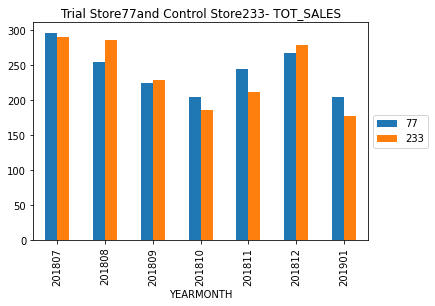

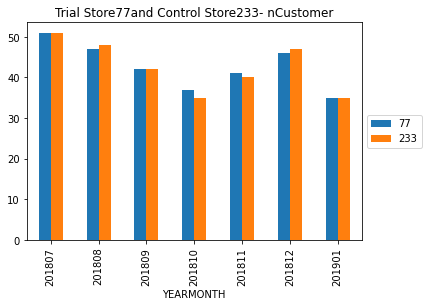

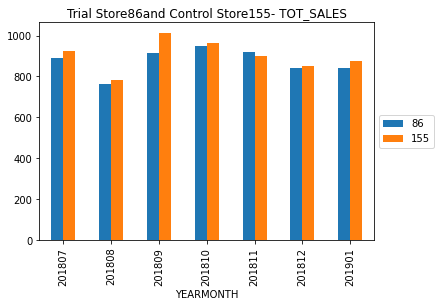

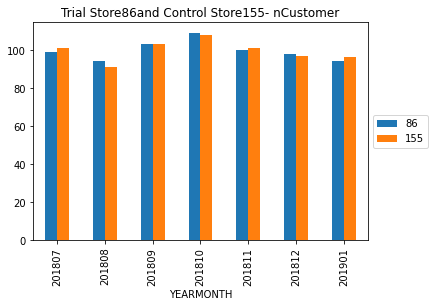

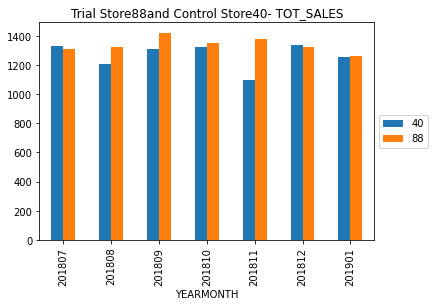

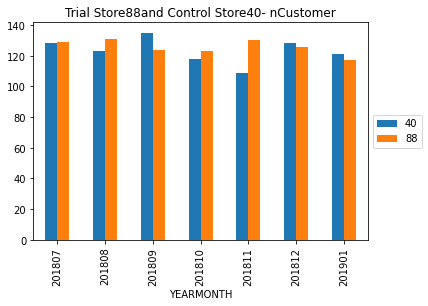

In [195]:
#Visual checks on trends based on the drivers
trial_control_dic = {77:233, 86:155, 88:40}
for key,val in trial_control_dic.items():
    pretrial_full_observ[pretrial_full_observ["STORE_NBR"].isin([key, val])].groupby(["YEARMONTH", "STORE_NBR"]).sum()["TOT_SALES"].unstack().plot.bar()
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.title("Trial Store"+str(key)+"and Control Store"+str(val)+"- TOT_SALES")
    plt.show()
    pretrial_full_observ[pretrial_full_observ["STORE_NBR"].isin([key, val])].groupby(["YEARMONTH", "STORE_NBR"]).sum()["nCustomers"].unstack().plot.bar()
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.title("Trial Store"+str(key)+"and Control Store"+str(val)+"- nCustomer")
    plt.show()
    print('\n')

In [196]:
#Scale pre-trial control sales to match pre-trial trial store sales 
ncust_ratio_77 = pretrial_full_observ[pretrial_full_observ["STORE_NBR"] == 77]["TOT_SALES"].sum() / pretrial_full_observ[pretrial_full_observ["STORE_NBR"] == 233]["TOT_SALES"].sum()
ncust_ratio_86 = pretrial_full_observ[pretrial_full_observ["STORE_NBR"] == 86]["TOT_SALES"].sum() / pretrial_full_observ[pretrial_full_observ["STORE_NBR"] == 155]["TOT_SALES"].sum()
ncust_ratio_88 = pretrial_full_observ[pretrial_full_observ["STORE_NBR"] == 88]["TOT_SALES"].sum() / pretrial_full_observ[pretrial_full_observ["STORE_NBR"] == 40]["TOT_SALES"].sum()

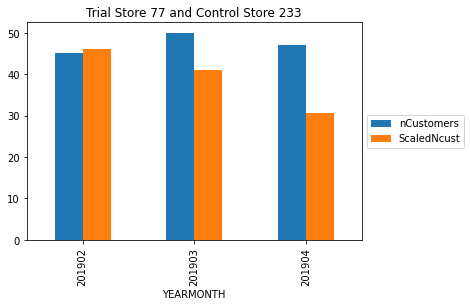

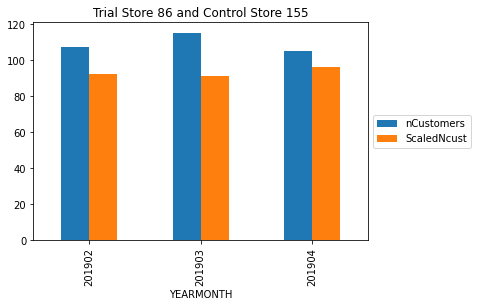

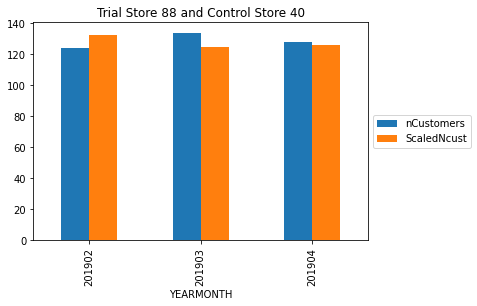

In [205]:
#trial_full_observ = full_observ[(full_observ["YEARMONTH"] >= 201902) & (full_observ["YEARMONTH"] <= 201904)]
scaled_ncust_control_stores = full_observ[full_observ["STORE_NBR"].isin([233, 155, 40])][["STORE_NBR", "YEARMONTH", "nCustomers"]]

def scaler_c(row):
    if row["STORE_NBR"] == 233:
        return row["nCustomers"] * ncust_ratio_77
    elif row["STORE_NBR"] == 155:
        return row["nCustomers"] * ncust_ratio_86
    elif row["STORE_NBR"] == 40:
        return row["nCustomers"] * ncust_ratio_88

scaled_ncust_control_stores["ScaledNcust"] = scaled_ncust_control_stores.apply(lambda row: scaler_c(row), axis=1)

trial_scaled_ncust_control_stores = scaled_ncust_control_stores[(scaled_ncust_control_stores["YEARMONTH"] >= 201902) & (scaled_ncust_control_stores["YEARMONTH"] <= 201904)]
pretrial_scaled_ncust_control_stores = scaled_ncust_control_stores[scaled_ncust_control_stores["YEARMONTH"] < 201902]

ncust_percentage_diff = {}

for trial, control in trial_control_dic.items():
    a = trial_scaled_ncust_control_stores[trial_scaled_ncust_control_stores["STORE_NBR"] == control]
    b = trial_full_observ[trial_full_observ["STORE_NBR"] == trial][["STORE_NBR", "YEARMONTH", "nCustomers"]]
    ncust_percentage_diff[trial] = b["nCustomers"].sum() / a["ScaledNcust"].sum()
    b[["YEARMONTH", "nCustomers"]].merge(a[["YEARMONTH", "ScaledNcust"]],on="YEARMONTH").set_index("YEARMONTH").rename(columns={"ScaledSales":"Scaled_Control_nCust", "TOT_SALES":"Trial_nCust"}).plot.bar()
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.title("Trial Store "+str(trial)+" and Control Store "+str(control))

In [206]:
#see if the difference is significant
percentage_diff

{77: 1.2615468650086281, 86: 1.1315014357363697, 88: 1.043458345854219}

In [199]:
temp1 = scaled_sales_control_stores.sort_values(by=["STORE_NBR", "YEARMONTH"], ascending=[False, True]).reset_index().drop(["TOT_SALES", "index"], axis=1)
temp2 = full_observ[full_observ["STORE_NBR"].isin([77,86,88])][["STORE_NBR", "YEARMONTH", "TOT_SALES"]].reset_index().drop(["index", "YEARMONTH"], axis=1)
scaledsales_vs_trial = pd.concat([temp1, temp2], axis=1)
scaledsales_vs_trial.columns = ["c_STORE_NBR", "YEARMONTH", "c_ScaledSales", "t_STORE_NBR", "t_TOT_SALES"]
scaledsales_vs_trial["Sales_Percentage_Diff"] = (scaledsales_vs_trial["t_TOT_SALES"] - scaledsales_vs_trial["c_ScaledSales"]) / (((scaledsales_vs_trial["t_TOT_SALES"] + scaledsales_vs_trial["c_ScaledSales"])/2))
def label_period(cell):
    if cell < 201902:
        return "pre"
    elif cell > 201904:
        return "post"
    else:
        return "trial"
scaledsales_vs_trial["trial_period"] = scaledsales_vs_trial["YEARMONTH"].apply(lambda cell: label_period(cell))
scaledsales_vs_trial[scaledsales_vs_trial["trial_period"] == "trial"]

,c_STORE_NBR,YEARMONTH,c_ScaledSales,t_STORE_NBR,t_TOT_SALES,Sales_Percentage_Diff,trial_period
7,233,201902,249.762622,77,235.0,-0.060907,trial
8,233,201903,203.802205,77,278.5,0.309755,trial
9,233,201904,162.345704,77,263.5,0.475075,trial
19,155,201902,864.522060,86,913.2,0.054764,trial
20,155,201903,780.320405,86,1026.8,0.272787,trial
21,155,201904,819.317024,86,848.2,0.034642,trial
31,40,201902,1434.399269,88,1370.2,-0.045781,trial
32,40,201903,1352.064709,88,1477.2,0.088458,trial
33,40,201904,1321.797762,88,1439.4,0.085182,trial


In [200]:
#check null hypothesis of 0 difference between control store's Pre-Trial and Trial period performance 
#conduct t test
from scipy.stats import ttest_ind, ttest_ind_from_stats

for num in [40, 155, 233]:
    print("Store", num) 
    print(ttest_ind(pretrial_scaled_sales_control_stores[pretrial_scaled_sales_control_stores["STORE_NBR"] == num]["ScaledSales"],
                   trial_scaled_sales_control_stores[trial_scaled_sales_control_stores["STORE_NBR"] == num]["ScaledSales"],
                   equal_var=False), '\n')
    
    
print("Critical t-value for 95% confidence interval:")
print(t.ppf((0.05/2, 1-0.05/2), df=min([len(pretrial_scaled_sales_control_stores[pretrial_scaled_sales_control_stores["STORE_NBR"] == num]),
                       len(trial_scaled_sales_control_stores[trial_scaled_sales_control_stores["STORE_NBR"] == num])])-1))


Store 40
Ttest_indResult(statistic=-0.5958372343168558, pvalue=0.5722861621434027) 

Store 155
Ttest_indResult(statistic=1.4291956879290917, pvalue=0.1972705865160342) 

Store 233
Ttest_indResult(statistic=1.1911026010974521, pvalue=0.2944500606486209) 

Critical t-value for 95% confidence interval:
[-4.30265273  4.30265273]


In [201]:
#check whether the hypothesis is statistically significant.
for trial, cont in trial_control_dic.items():
    print("Trial store:", trial, ", Control store:", cont)
    print(ttest_ind(pretrial_full_observ[pretrial_full_observ["STORE_NBR"] == trial]["TOT_SALES"],
                   pretrial_scaled_sales_control_stores[pretrial_scaled_sales_control_stores["STORE_NBR"] == cont]["ScaledSales"],
                   equal_var=True), '\n')
    

alpha = 0.05
print("Critical t-value for 95% confidence interval:")
print(t.ppf((alpha/2, 1-alpha/2), df=len(pretrial_full_observ[pretrial_full_observ["STORE_NBR"] == trial])-1))
     
#null hypothesis is true. There's no statistically significant difference between trial store sales & control store's scaled-sales performanca during pre-trial)

Trial store: 77 , Control store: 233
Ttest_indResult(statistic=-1.2533353315065932e-15, pvalue=0.999999999999999) 

Trial store: 86 , Control store: 155
Ttest_indResult(statistic=3.1048311203382156e-15, pvalue=0.9999999999999976) 

Trial store: 88 , Control store: 40
Ttest_indResult(statistic=-5.69358613974361e-15, pvalue=0.9999999999999956) 

Critical t-value for 95% confidence interval:
[-2.44691185  2.44691185]


In [202]:
#check Null Hypothesis of Percentage Difference between Trial and Control stores during pre-trial is the same as during trial
for trial, cont in trial_control_dic.items():
    print("Trial store:", ",Control store:", cont)
    temp_pre = scaledsales_vs_trial[(scaledsales_vs_trial["c_STORE_NBR"] == cont) & (scaledsales_vs_trial["trial_period"]=="pre")]
    std = temp_pre["Sales_Percentage_Diff"].std()
    mean = temp_pre["Sales_Percentage_Diff"].mean()
    
    for t_month in scaledsales_vs_trial[scaledsales_vs_trial["trial_period"] == "trial"]["YEARMONTH"].unique():
        pdif = scaledsales_vs_trial[(scaledsales_vs_trial["YEARMONTH"] == t_month) & (scaledsales_vs_trial["t_STORE_NBR"] == trial)]["Sales_Percentage_Diff"]
        print(t_month,":",(float(pdif)-mean)/std) 
    print('\n')
    
print("Critical t-value for 95% confidence interval:")
conf_intv_95 = t.ppf(0.95, df=len(temp_pre)-1)
print(conf_intv_95)

#3 months' increase in performance that are statistically significant(above the 95% confidence interval t-score)
#march and april trial months for trial store 77 
#march trial months for trial store 86         

Trial store: ,Control store: 233
201902 : -0.7171038288055838
201903 : 3.035317928855674
201904 : 4.708944418758219


Trial store: ,Control store: 155
201902 : 1.4133618775921597
201903 : 7.123063846042147
201904 : 0.8863824572944234


Trial store: ,Control store: 40
201902 : -0.5481633746817577
201903 : 1.0089992743637823
201904 : 0.9710006270463672


Critical t-value for 95% confidence interval:
1.9431802803927816


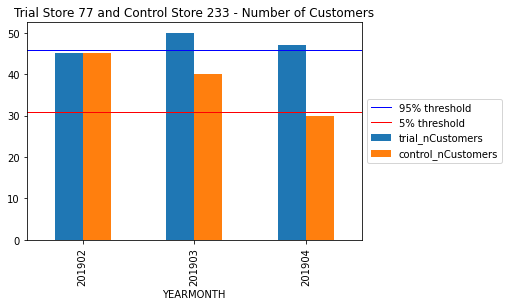

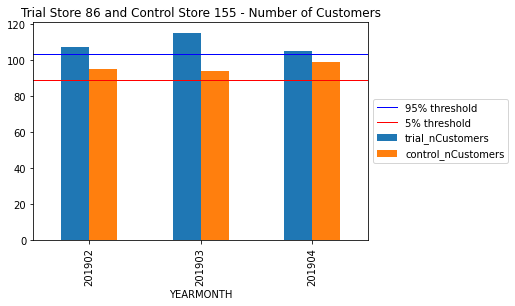

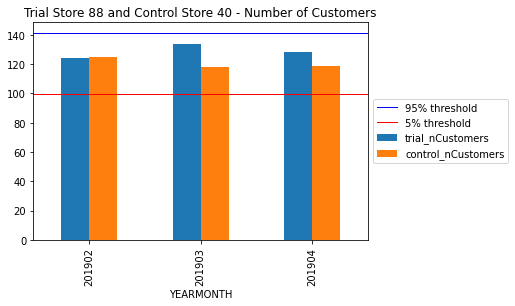

In [210]:

for trial, control in trial_control_dic.items():
    a = trial_scaled_ncust_control_stores[trial_scaled_ncust_control_stores["STORE_NBR"] == control].rename(columns={"nCustomers": "control_nCustomers"})
    b = trial_full_observ[trial_full_observ["STORE_NBR"] == trial][["STORE_NBR", "YEARMONTH", "nCustomers"]].rename(columns={"nCustomers": "trial_nCustomers"})
    comb = b[["YEARMONTH", "trial_nCustomers"]].merge(a[["YEARMONTH", "control_nCustomers"]],on="YEARMONTH").set_index("YEARMONTH")
    comb.plot.bar()
    cont_sc_ncust = trial_scaled_ncust_control_stores[trial_scaled_ncust_control_stores["STORE_NBR"] == control]["nCustomers"]
    std = scaledsales_vs_trial[(scaledsales_vs_trial["c_STORE_NBR"] == control) & (scaledsales_vs_trial["trial_period"]=="pre")]["Sales_Percentage_Diff"].std()
    thresh95 = cont_sc_ncust.mean() + (cont_sc_ncust.mean() * std * 2)
    thresh5 = cont_sc_ncust.mean() - (cont_sc_ncust.mean() * std * 2)
    plt.axhline(y=thresh95,linewidth=1, color='b', label="95% threshold")
    plt.axhline(y=thresh5,linewidth=1, color='r', label="5% threshold")
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.title("Trial Store "+str(trial)+" and Control Store "+str(control)+" - Number of Customers")
    plt.savefig("TS {} and CS {} - nCustomers.png".format(trial,control), bbox_inches="tight")
     

In [ ]:
#trial store 77 sales for feb, march and april exceeeds 95% threshold of control store. the same goes to store 86 sales for all 3 trial months. 
#the trial showed positive significant result 
